# 1 - Import Required Libraries
Import all necessary libraries for rheological data analysis:
- pandas: Data manipulation and CSV handling
- numpy: Numerical operations
- matplotlib/seaborn: Visualization
- scipy: Curve fitting for rheological models

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


In [45]:
# HY500 datasets - Single file containing all data
file_paths = ['dynamic_analysis_cell_1_20251119_153055.csv']

# Since we have only one file, create a single dataset name
dataset_names = ["HY500 Sample"]

# Load the single dataset
datasets = []
for idx, path in enumerate(file_paths):
    try:
        df = pd.read_csv(path)
        # Remove columns with 'Unnamed' in their name (these are empty columns)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        datasets.append(df)
        print(f"✓ Loaded: {dataset_names[idx]}")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
    except Exception as e:
        print(f"✗ Error loading {path}: {e}")

print(f"\n📊 Total datasets loaded: {len(datasets)}")

# Preview first dataset if loaded successfully
if len(datasets) > 0:
    datasets[0]
else:
    print("No datasets loaded successfully")

✓ Loaded: HY500 Sample
   Shape: (32, 19)
   Columns: ['Z-Height', 'RPM_0.1', 'RPM_0.2', 'RPM_0.3', 'RPM_0.4', 'RPM_0.5', 'RPM_0.7', 'RPM_0.9', 'RPM_1.0', 'RPM_1.2', 'RPM_1.5', 'RPM_2.0', 'RPM_2.2', 'RPM_2.5', 'RPM_3.0', 'RPM_3.5', 'RPM_4.0', 'RPM_4.5', 'RPM_10.0']

📊 Total datasets loaded: 1


# 2 - Load Datasets
Load all datasets for analysis. 
Modify the file paths and names to match your data.
The pipeline will automatically process all loaded datasets.

* Visocmeter settings:
     - Brand: Brookfield
     - Model: DV2T
     - Spindle: CPE-52
* Automated data collection setup using CNC machine:
     - Brand: Genmitsu 4040-pro
     - Controller: GRBL
     - Container: 6 cells in a grid of 6x1

# Define Rheometer Parameters
- Set up rheometer geometry and measurement parameters.
- These values are used for stress and strain calculations.
- Adjust these based on your specific rheometer configuration.

In [46]:
# Rheometer parameters
ALPHA_DEG = 3.0       # Cone half-angle in degrees
R_CM = 1.2            # Cone radius in cm
M_MAX = 7.187e-3      # Maximum torque in N·m (for 100% torque)
GAP_UM = 327           # Gap between cone tip and plate in micrometers

print("Rheometer Configuration:")
print(f"  Cone angle: {ALPHA_DEG}°")
print(f"  Cone radius: {R_CM} cm")
print(f"  Max torque: {M_MAX} N·m")
print(f"  Gap: {GAP_UM} μm")

Rheometer Configuration:
  Cone angle: 3.0°
  Cone radius: 1.2 cm
  Max torque: 0.007187 N·m
  Gap: 327 μm


# Function to Plot Raw Torque vs Speed Data
- Plot raw experimental data: Torque (%) vs Spindle Speed (rpm)
- This shows the direct measurements from the rheometer before any processing.

In [47]:
def plot_raw_torque_vs_speed(datasets, dataset_names):
    """
    Plot Torque (%) vs Spindle Speed (rpm) for all datasets in a single wide plot.
    
    Parameters:
    -----------
    datasets : list of pd.DataFrame
        Each DataFrame contains height in first column, torque values in subsequent columns
    dataset_names : list of str
        Names for each dataset to use in the plot title
    """
    # Create a single wide figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot data from all datasets on the same plot
    for idx, df in enumerate(datasets):
        # Extract data
        heights = df.iloc[:, 0]  # First column = height
        speed_labels = df.columns[1:]  # Remaining columns = RPM data
        speeds = [float(label.replace('RPM_', '')) for label in speed_labels]
        torque_data = df.iloc[:, 1:]
        
        # Plot each height as a separate series
        for i in range(len(heights)):
            if pd.notna(heights.iloc[i]):  # Only plot valid heights
                ax.scatter(speeds, torque_data.iloc[i, :],
                          label=f"h={heights.iloc[i]:.3f} mm", s=30, alpha=0.7)
    
    # Formatting
    ax.set_xlabel("Spindle Speed (rpm)", fontsize=12)
    ax.set_ylabel("Torque (%)", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.set_title(f"{' & '.join(dataset_names)} - Raw Torque vs Speed", fontsize=14, pad=15)
    ax.legend(title="Height (mm)", fontsize="small", loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()

# Plot Raw Data
- Execute the raw data visualization.
- This provides a quick check of data quality and measurement consistency.

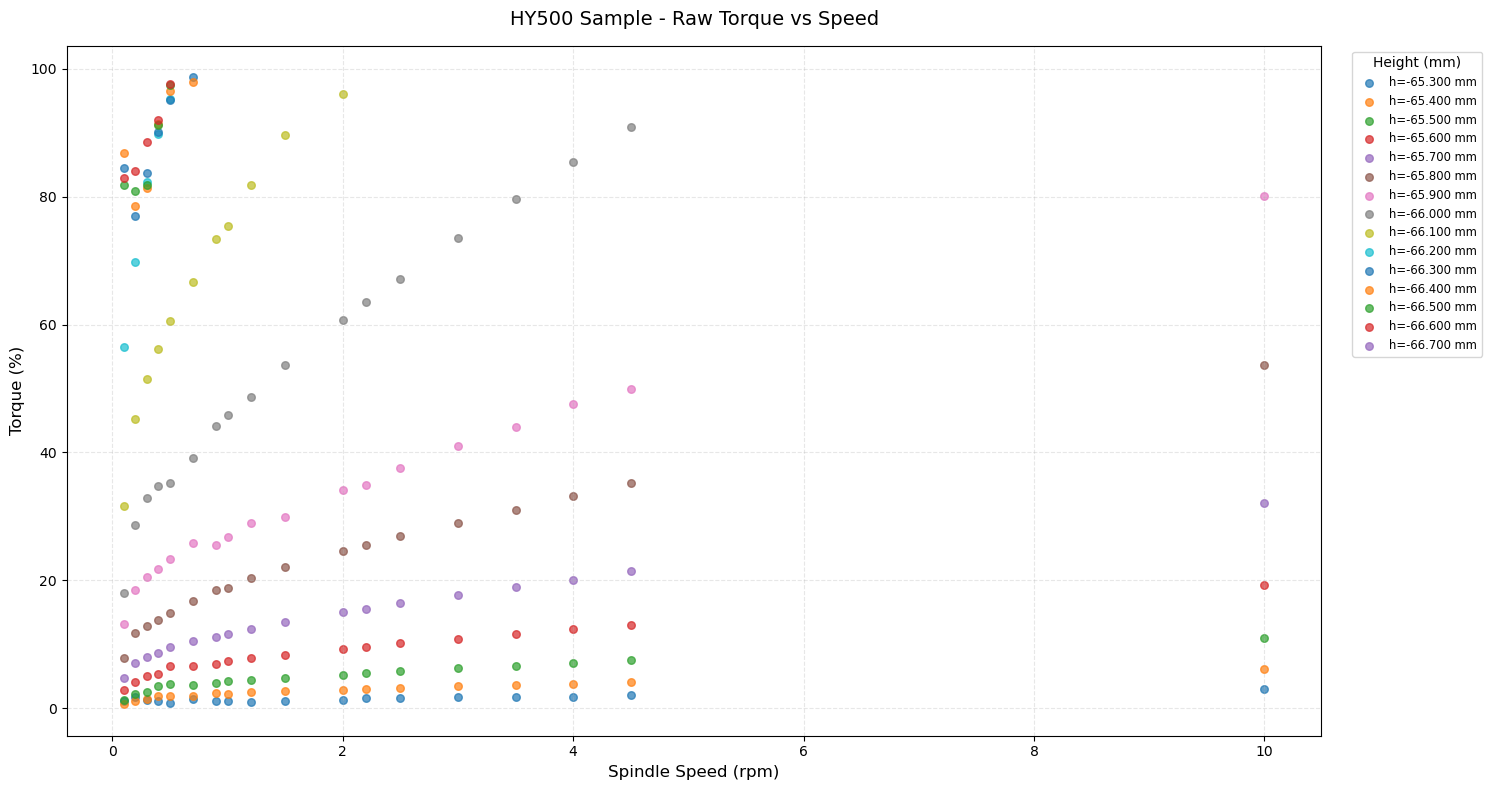

In [48]:
plot_raw_torque_vs_speed(datasets, dataset_names)

# Function to Compute Stress and Strain
Convert raw torque and speed measurements to fundamental rheological quantities:
- Shear stress (τ, Pa): Force per unit area
- Shear rate (γ̇, 1/s): Velocity gradient in the fluid

Includes finite-gap correction for cone-plate geometry.

In [49]:
def compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um):
    """
    Compute shear stress (Pa) and shear rate (1/s) from raw measurements.
    Applies finite-gap correction for cone-plate geometry.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with height in first column, torque values in remaining columns
    alpha_deg : float
        Cone half-angle in degrees
    R_cm : float
        Cone radius in cm
    M_max : float
        Maximum torque in N·m (corresponding to 100% torque)
    gap_um : float
        Gap between cone tip and plate in micrometers
    
    Returns:
    --------
    results : dict
        {height_mm: (gamma_dot_array, tau_array)}
        gamma_dot: shear rate in 1/s
        tau: shear stress in Pa
    """
    # Convert units
    alpha = np.deg2rad(alpha_deg)  # degrees to radians
    R = R_cm / 100.0               # cm to meters
    h0 = gap_um * 1e-6             # micrometers to meters
    
    # Finite-gap correction factor
    # Accounts for deviation from ideal cone-plate geometry
    fc = 1 - (3 * h0) / (2 * R * np.tan(alpha))
    
    # Extract RPM values from column headers
    speed_labels = df.columns[1:]
    speeds = np.array([float(label.replace('RPM_', '')) for label in speed_labels])
    
    results = {}
    
    for i in range(len(df)):
        height = df.iloc[i, 0]
        torque_percent = df.iloc[i, 1:].values
        
        # Convert torque from % to N·m
        torque = (torque_percent / 100) * M_max
        
        # Calculate shear stress with finite-gap correction
        # Formula: τ = fc * (3M) / (2πR³)
        tau = fc * (3 * torque) / (2 * np.pi * R**3)  # Pa
        
        # Calculate shear rate
        # Convert RPM to angular velocity (rad/s)
        Omega = 2 * np.pi * speeds / 60  # rad/s
        # For cone-plate: γ̇ = Ω / tan(α)
        gamma_dot = Omega / np.tan(alpha)  # 1/s
        
        results[height] = (gamma_dot, tau)
    
    return results

# Define Rheological Models
Define mathematical models to fit stress-strain relationships:
1. Power-law model: τ = K·γ̇ⁿ (for non-Newtonian fluids)
2. Linear model: τ = a·γ̇ + b (for Newtonian fluids)

In [50]:
def power_law(gamma_dot, K, n):
    """
    Power-law fluid model: τ = K·γ̇ⁿ
    
    Parameters:
    -----------
    gamma_dot : array
        Shear rate (1/s)
    K : float
        Consistency index (Pa·sⁿ)
    n : float
        Flow behavior index (dimensionless)
        n < 1: shear-thinning
        n = 1: Newtonian
        n > 1: shear-thickening
    
    Returns:
    --------
    tau : array
        Shear stress (Pa)
    """
    return K * gamma_dot**n


def linear_model(gamma_dot, a, b):
    """
    Linear (Newtonian) model: τ = a·γ̇ + b
    
    Parameters:
    -----------
    gamma_dot : array
        Shear rate (1/s)
    a : float
        Slope = viscosity (Pa·s)
    b : float
        Intercept (Pa), ideally close to zero
    
    Returns:
    --------
    tau : array
        Shear stress (Pa)
    """
    return a * gamma_dot + b

# Function to Plot Fitted Stress-Strain Curves
- Plot shear stress vs shear rate with fitted curves.
- This reveals the rheological behavior of the material.

In [51]:
def plot_fitted_stress_strain(datasets, dataset_names, alpha_deg, R_cm, 
                              M_max, gap_um, fit_method="linear"):
    """
    Plot τ vs γ̇ with fitted curves for all datasets in a single wide plot.
    
    Parameters:
    -----------
    datasets : list of pd.DataFrame
        List of datasets to analyze
    dataset_names : list of str
        Names for each dataset
    alpha_deg, R_cm, M_max, gap_um : float
        Rheometer parameters
    fit_method : str
        "linear" or "power_law"
    """
    # Create a single wide figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot data from all datasets on the same plot
    for idx, df in enumerate(datasets):
        # Compute stress and strain for this dataset
        results = compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um)
        
        for h, (gdot, tau) in results.items():
            # Skip NaN heights
            if pd.isna(h):
                continue
                
            # Filter positive values only (required for log scale)
            mask = (gdot > 0) & (tau > 0)
            gdot_fit, tau_fit = gdot[mask], tau[mask]
            
            if len(gdot_fit) < 3:  # Need at least 3 points to fit
                continue
            
            # Fit the selected model
            try:
                if fit_method == "power_law":
                    model = power_law
                    p0 = [0.1, 1]  # Initial guess: K=0.1, n=1
                    popt, _ = curve_fit(model, gdot_fit, tau_fit, p0=p0)
                    K, n = popt
                    
                    # Generate smooth curve for plotting
                    g_line = np.logspace(np.log10(gdot_fit.min()), 
                                        np.log10(gdot_fit.max()), 100)
                    tau_line = model(g_line, *popt)
                    label_fit = f"Fit h={h:.2f}: τ={K:.2e}·γ̇^{n:.2f}"
                
                elif fit_method == "linear":
                    model = linear_model
                    p0 = [1, 0]  # Initial guess: slope=1, intercept=0
                    popt, _ = curve_fit(model, gdot_fit, tau_fit, p0=p0)
                    a, b = popt
                    
                    # Generate smooth line for plotting
                    g_line = np.linspace(gdot_fit.min(), gdot_fit.max(), 100)
                    tau_line = model(g_line, *popt)
                    label_fit = f"Fit h={h:.2f}: τ={a:.2e}·γ̇+{b:.2e}"
                
                # Plot experimental data and fitted curve
                ax.scatter(gdot_fit, tau_fit, s=30, label=f"h={h:.2f} mm", alpha=0.7)
                ax.plot(g_line, tau_line, '--', lw=1.5, alpha=0.8)
                
            except Exception as e:
                # Skip points that can't be fitted
                continue
    
    # Set scale (log for power-law, linear for Newtonian)
    if fit_method == "power_law":
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    # Formatting
    ax.set_xlabel("Shear Rate γ̇ (1/s)", fontsize=12)
    ax.set_ylabel("Shear Stress τ (Pa)", fontsize=12)
    ax.set_title(f"{' & '.join(dataset_names)} - {fit_method.replace('_',' ').title()} Model", fontsize=14, pad=15)
    ax.grid(True, which="both", ls="--", alpha=0.3)
    ax.legend(fontsize="small", frameon=True, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    plt.show()

# Plot Fitted Data with Linear Model
- Execute stress-strain analysis with linear (Newtonian) model.
- The slope of each fit represents the dynamic viscosity.

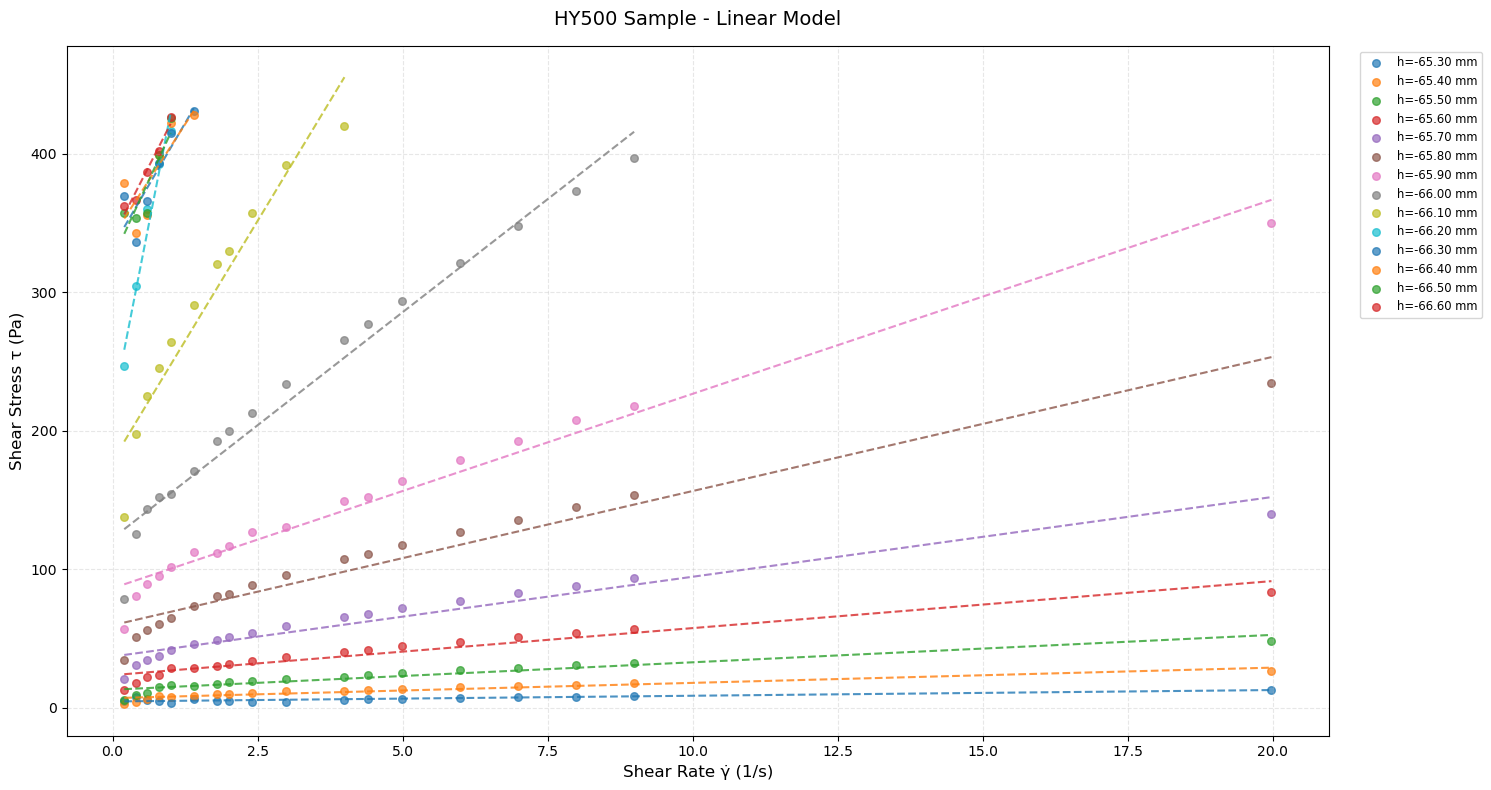

In [52]:
plot_fitted_stress_strain(datasets, dataset_names, ALPHA_DEG, R_CM, 
                          M_MAX, GAP_UM, fit_method="linear")

# Plot with Power-Law Model
- Alternative: Use power-law model for non-Newtonian fluids.
- Uncomment to visualize shear-thinning or shear-thickening behavior.

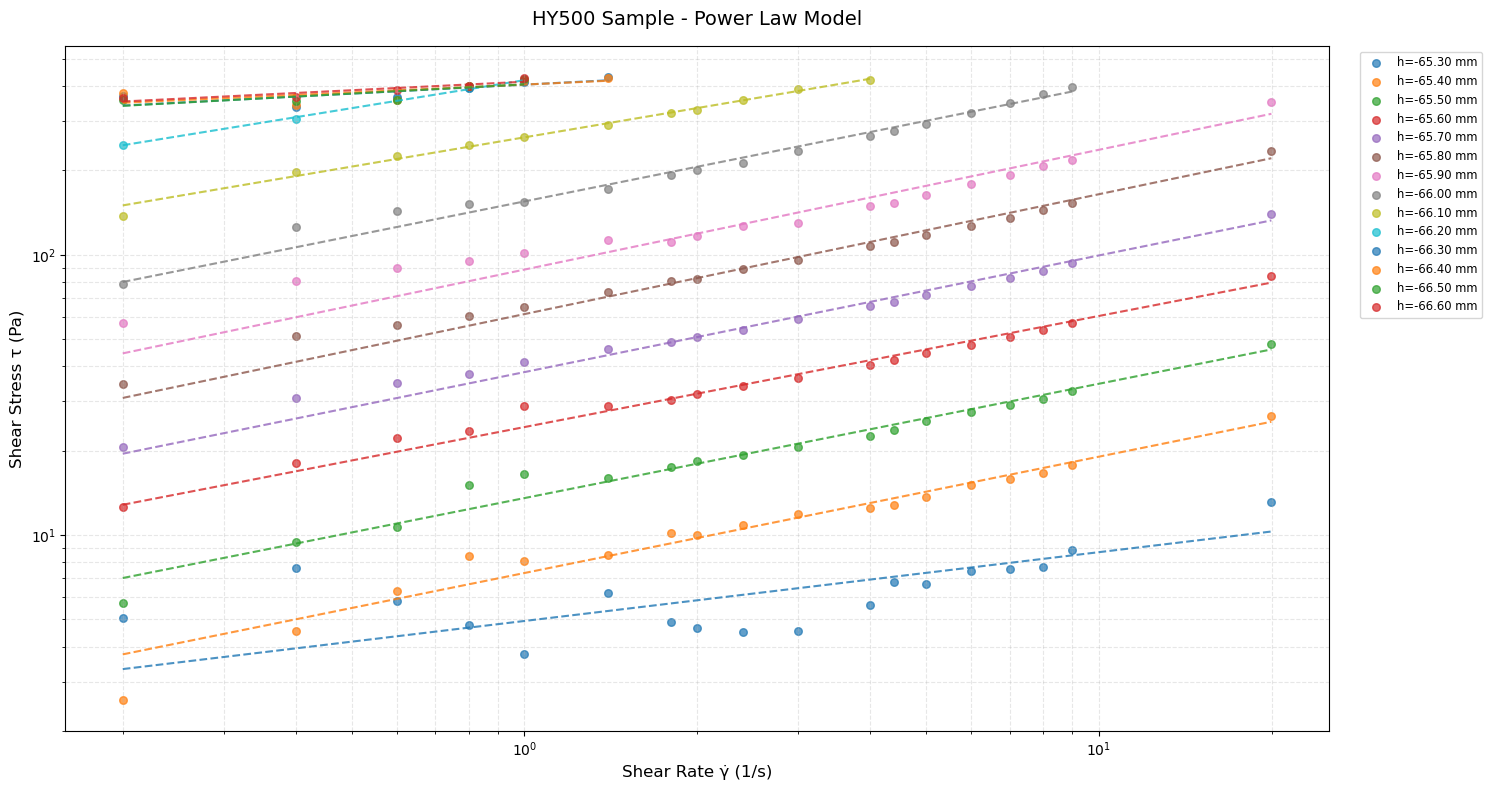

In [53]:
plot_fitted_stress_strain(datasets, dataset_names, ALPHA_DEG, R_CM, 
                          M_MAX, GAP_UM, fit_method="power_law")

# Function to Extract Viscosity from Fits
- Extract viscosity values from the fitted curves.
- For linear fits: viscosity = slope (a)
- For power-law fits: apparent viscosity = K·γ̇^(n-1) at mean shear rate

In [54]:
def extract_viscosity_data(datasets, dataset_names, alpha_deg, R_cm, 
                          M_max, gap_um, fit_method="linear"):
    """
    Extract viscosity (Pa·s) from fitted data for all datasets.
    
    Parameters:
    -----------
    datasets : list of pd.DataFrame
        List of datasets to analyze
    dataset_names : list of str
        Names for each dataset
    alpha_deg, R_cm, M_max, gap_um : float
        Rheometer parameters
    fit_method : str
        "linear" or "power_law"
    
    Returns:
    --------
    viscosity_data : dict
        {dataset_name: [viscosity_values_in_Pa_s]}
    """
    viscosity_data = {}
    
    for idx, df in enumerate(datasets):
        results = compute_stress_strain(df, alpha_deg, R_cm, M_max, gap_um)
        viscosities = []
        
        for h, (gdot, tau) in results.items():
            mask = (gdot > 0) & (tau > 0)
            gdot_fit, tau_fit = gdot[mask], tau[mask]
            
            if len(gdot_fit) < 3:
                continue
            
            if fit_method == "power_law":
                # Fit power-law model
                popt, _ = curve_fit(power_law, gdot_fit, tau_fit, p0=[0.1, 1])
                K, n = popt
                # Calculate apparent viscosity at mean shear rate
                # η_app = K·γ̇^(n-1)
                g_mean = np.mean(gdot_fit)
                eta_app = K * g_mean**(n - 1)
                viscosities.append(eta_app)
            
            elif fit_method == "linear":
                # Fit linear model
                popt, _ = curve_fit(linear_model, gdot_fit, tau_fit, p0=[1, 0])
                a, b = popt
                # For Newtonian fluid: viscosity = slope
                viscosities.append(a)
        
        viscosity_data[dataset_names[idx]] = viscosities
    
    return viscosity_data

# Extract Viscosity Values
Extract viscosity from all datasets using the linear model.

In [55]:
viscosity_data = extract_viscosity_data(datasets, dataset_names, ALPHA_DEG, 
                                       R_CM, M_MAX, GAP_UM, fit_method="linear")

# Display summary statistics
for name, values in viscosity_data.items():
    if values:
        print(f"{name}:")
        print(f"  Mean: {np.mean(values)*1000:.2f} cP")
        print(f"  Std:  {np.std(values)*1000:.2f} cP")
        print(f"  Min:  {np.min(values)*1000:.2f} cP")
        print(f"  Max:  {np.max(values)*1000:.2f} cP")
        print()

HY500 Sample:
  Mean: 47250.08 cP
  Std:  56694.50 cP
  Min:  411.89 cP
  Max:  213823.91 cP



# Function to Plot Viscosity Comparison
- Create a boxplot comparing viscosity distributions across all datasets.
- This reveals measurement consistency and inter-sample variability.

In [56]:
def plot_viscosity_boxplot(viscosity_data, fit_method="linear"):
    """
    Plot boxplot comparing viscosity distributions across datasets.
    
    Parameters:
    -----------
    viscosity_data : dict
        {dataset_name: [viscosity_values_in_Pa_s]}
    fit_method : str
        "linear" or "power_law" (for plot title)
    
    Returns:
    --------
    df_vis : pd.DataFrame
        DataFrame with columns ['Dataset', 'Viscosity_cP'] for further analysis
    """
    # Convert to DataFrame format for seaborn
    rows = []
    for name, viscosities in viscosity_data.items():
        for v in viscosities:
            rows.append({
                "Dataset": name, 
                "Viscosity_cP": v * 1000  # Convert Pa·s to cP
            })
    
    df_vis = pd.DataFrame(rows)
    
    if df_vis.empty:
        print("⚠️ No valid viscosity data to plot.")
        return None
    
    # Create boxplot
    plt.figure(figsize=(max(10, len(viscosity_data) * 1.5), 6))
    sns.boxplot(x="Dataset", y="Viscosity_cP", data=df_vis,
               palette="Blues", showmeans=True,
               meanprops={"marker": "o", "markerfacecolor": "red",
                         "markeredgecolor": "black", "markersize": 6})
    
    plt.title(f"Viscosity Distribution ({fit_method.replace('_', ' ').title()} Fit)",
             fontsize=14, pad=12)
    plt.ylabel("Viscosity (cP)")
    plt.xlabel("Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return df_vis

# Plot Viscosity Comparison
- Execute viscosity comparison visualization.
- Red diamonds indicate mean values, boxes show quartiles.

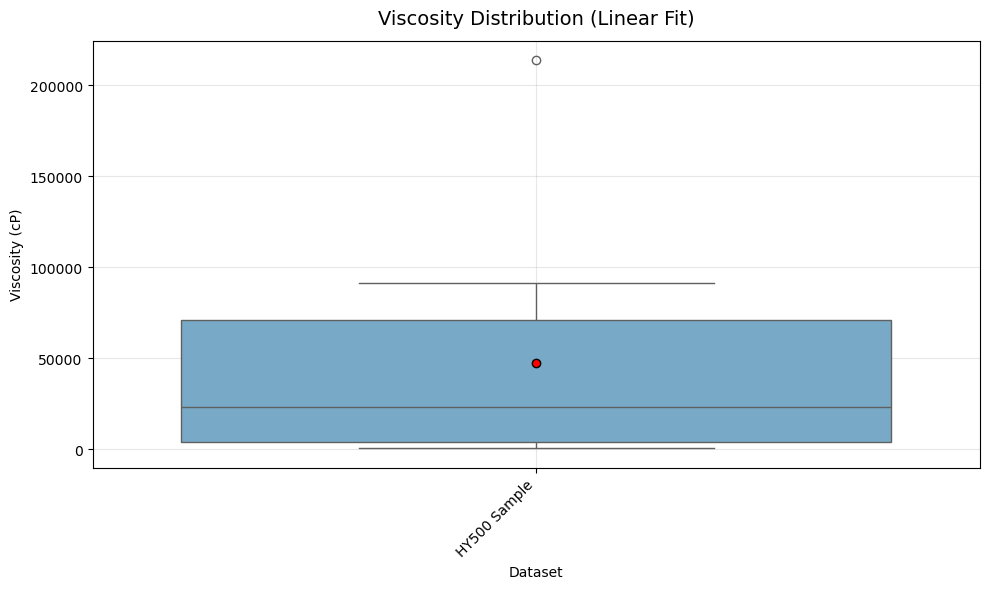


Viscosity Data Summary:
              count          mean           std         min          25%  \
Dataset                                                                    
HY500 Sample   14.0  47250.076095  58834.663163  411.891026  3987.621122   

                       50%           75%            max  
Dataset                                                  
HY500 Sample  23333.973194  70970.331243  213823.912152  


In [57]:
df_viscosity = plot_viscosity_boxplot(viscosity_data, fit_method="linear")

# Display the viscosity data table
print("\nViscosity Data Summary:")
print(df_viscosity.groupby('Dataset')['Viscosity_cP'].describe())

# COMPLETE PIPELINE SUMMARY
AUTOMATED RHEOLOGY ANALYSIS PIPELINE

To analyze a new dataset:
1. Update file paths in CELL 2
2. Verify rheometer parameters in CELL 3
3. Run all cells sequentially

The pipeline automatically:
✓ Loads and validates data
✓ Plots raw measurements
✓ Computes stress and strain
✓ Fits rheological models
✓ Extracts viscosity values
✓ Generates comparison plots

Outputs:
- Raw torque vs speed plots
- Fitted stress-strain curves
- Viscosity distribution comparison
- Statistical summary tables